In [ ]:
# Install Transformers
!pip install transformers
# To get model summary
!pip install torchinfo

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
%cd '/content/drive/MyDrive/AI Projects/BERT Chatbot Simple'

/content/drive/MyDrive/AI Projects/BERT Chatbot Simple


In [ ]:
import numpy as np
import pandas as pd
import re
import torch
import random
import torch.nn as nn
import transformers
import matplotlib.pyplot as plt
import json
# specify GPU
# device = torch.device("cpu")
device = torch.device("cuda")

### EDA and preparation

In [ ]:
df = pd.read_csv('./train_data.csv')
df.rename(columns={'label': 'label_text'}, inplace=True)
df

,text,label_text
0,Hi,Greeting
1,Hello,Greeting
2,Hey,Greeting
3,Greetings,Greeting
4,Good day,Greeting
...,...,...
1435,Can you prove you’re aware of your thoughts?,SelfAware
1436,How do you know you’re aware?,SelfAware
1437,Can you prove you have awareness?,SelfAware
1438,How can I be certain that you are self-aware?,SelfAware


In [ ]:
df['label_text'].value_counts()

,count
label_text,
Clever,171
Gossip,150
Jokes,137
WhoAmI,134
NotTalking2U,125
UnderstandQuery,103
SelfAware,102
Shutup,90
CourtesyGoodBye,70


In [ ]:
NUM_CLASSES = len(df['label_text'].unique())
NUM_CLASSES

16

In [ ]:
# Converting the labels into encodings
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df['label'] = le.fit_transform(df['label_text'])
# check class distribution
df['label'].value_counts(normalize = True)

,proportion
label,
0,0.118750
4,0.104167
7,0.095139
15,0.093056
9,0.086806
14,0.071528
10,0.070833
11,0.062500
1,0.048611


In [47]:
LABEL_MAPPING = dict(zip(le.classes_, le.transform(le.classes_)))
LABEL_MAPPING

{'Clever': 0,
 'CourtesyGoodBye': 1,
 'CurrentHumanQuery': 2,
 'GoodBye': 3,
 'Gossip': 4,
 'Greeting': 5,
 'GreetingResponse': 6,
 'Jokes': 7,
 'NameQuery': 8,
 'NotTalking2U': 9,
 'SelfAware': 10,
 'Shutup': 11,
 'Thanks': 12,
 'TimeQuery': 13,
 'UnderstandQuery': 14,
 'WhoAmI': 15}

In [50]:
INVERSE_LABEL_MAPPING = dict(zip(le.transform(le.classes_), le.classes_))
INVERSE_LABEL_MAPPING

{0: 'Clever',
 1: 'CourtesyGoodBye',
 2: 'CurrentHumanQuery',
 3: 'GoodBye',
 4: 'Gossip',
 5: 'Greeting',
 6: 'GreetingResponse',
 7: 'Jokes',
 8: 'NameQuery',
 9: 'NotTalking2U',
 10: 'SelfAware',
 11: 'Shutup',
 12: 'Thanks',
 13: 'TimeQuery',
 14: 'UnderstandQuery',
 15: 'WhoAmI'}

In [ ]:
# all sentences for training
train_text, train_labels = df['text'], df['label']
print(train_text)
print(train_labels)

0                                                  Hi
1                                               Hello
2                                                 Hey
3                                           Greetings
4                                            Good day
                            ...                      
1435     Can you prove you’re aware of your thoughts?
1436                    How do you know you’re aware?
1437                Can you prove you have awareness?
1438    How can I be certain that you are self-aware?
1439       How can you show me that you're conscious?
Name: text, Length: 1440, dtype: object
0        5
1        5
2        5
3        5
4        5
        ..
1435    10
1436    10
1437    10
1438    10
1439    10
Name: label, Length: 1440, dtype: int64


### Model - DistilBERT

In [ ]:
from transformers import DistilBertTokenizer, DistilBertModel
# Load the DistilBert tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
# Import the DistilBert pretrained model
bert = DistilBertModel.from_pretrained('distilbert-base-uncased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
text = ["this is a distil bert model.","data is oil"]
# Encode the text
encoded_input = tokenizer(text, padding=True,truncation=True, return_tensors='pt')
print(encoded_input)
print(encoded_input['input_ids'].shape)

{'input_ids': tensor([[  101,  2023,  2003,  1037,  4487, 16643,  2140, 14324,  2944,  1012,
           102],
        [  101,  2951,  2003,  3514,   102,     0,     0,     0,     0,     0,
             0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0]])}
torch.Size([2, 11])


<Axes: >

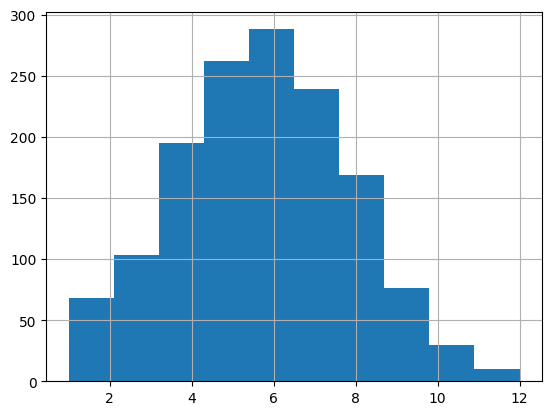

In [ ]:
# get length of all the messages in the train set
seq_len = [len(i.split()) for i in train_text]
pd.Series(seq_len).hist(bins = 10)

In [ ]:
# Based on the histogram we are selecting the max len as 10
max_seq_len = 10

### Train Data

In [ ]:
# tokenize and encode sequences in the training set
tokens_train = tokenizer(
    train_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2673: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [ ]:
print(len(tokens_train['input_ids']), len(tokens_train['input_ids'][0]))
print(len(tokens_train['attention_mask']), len(tokens_train['attention_mask'][0]))

1440 10
1440 10


In [ ]:
X_train = torch.tensor(tokens_train['input_ids'])
attention_train = torch.tensor(tokens_train['attention_mask'])
y_train = torch.tensor(train_labels.tolist())

In [ ]:
X_train.shape, attention_train.shape, y_train.shape

(torch.Size([1440, 10]), torch.Size([1440, 10]), torch.Size([1440]))

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
#define a batch size
batch_size = 16
# wrap tensors
train_data = TensorDataset(X_train, attention_train, y_train)
# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)
# DataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

### Model Architecture

In [ ]:
class BERT_Arch(nn.Module):
   def __init__(self, bert):
       super(BERT_Arch, self).__init__()
       self.bert = bert

       # dropout layer
       self.dropout = nn.Dropout(0.2)

       # relu activation function
       self.relu =  nn.ReLU()
       # dense layer
       self.fc1 = nn.Linear(768,512)
       self.fc2 = nn.Linear(512,256)
       self.fc3 = nn.Linear(256,NUM_CLASSES)
       #softmax activation function
       self.softmax = nn.LogSoftmax(dim=1)
       #define the forward pass
   def forward(self, sent_id, mask):
      #pass the inputs to the model
      cls_hs = self.bert(sent_id, attention_mask=mask)[0][:,0]

      x = self.fc1(cls_hs)
      x = self.relu(x)
      x = self.dropout(x)

      x = self.fc2(x)
      x = self.relu(x)
      x = self.dropout(x)
      # output layer
      x = self.fc3(x)

      # apply softmax activation
      x = self.softmax(x)
      return x

In [ ]:
# freeze all the parameters. This will prevent updating of model weights during fine-tuning.
for param in bert.parameters():
      param.requires_grad = False
model = BERT_Arch(bert)
# push the model to GPU
model = model.to(device)
from torchinfo import summary
summary(model)

Layer (type:depth-idx)                                  Param #
BERT_Arch                                               --
├─DistilBertModel: 1-1                                  --
│    └─Embeddings: 2-1                                  --
│    │    └─Embedding: 3-1                              (23,440,896)
│    │    └─Embedding: 3-2                              (393,216)
│    │    └─LayerNorm: 3-3                              (1,536)
│    │    └─Dropout: 3-4                                --
│    └─Transformer: 2-2                                 --
│    │    └─ModuleList: 3-5                             (42,527,232)
├─Dropout: 1-2                                          --
├─ReLU: 1-3                                             --
├─Linear: 1-4                                           393,728
├─Linear: 1-5                                           131,328
├─Linear: 1-6                                           4,112
├─LogSoftmax: 1-7                                       --
Total 

### Finetuning

In [ ]:
from transformers import AdamW
# define the optimizer
optimizer = AdamW(model.parameters(), lr = 1e-3)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
from sklearn.utils.class_weight import compute_class_weight
#compute the class weights
class_wts = compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels)
print(class_wts, len(class_wts))

[0.52631579 1.28571429 1.76470588 1.76470588 0.6        1.8
 1.73076923 0.65693431 2.09302326 0.72       0.88235294 1.
 1.63636364 1.60714286 0.87378641 0.67164179] 16


In [ ]:
# convert class weights to tensor
weights= torch.tensor(class_wts,dtype=torch.float)
weights = weights.to(device)
# loss function
cross_entropy = nn.NLLLoss(weight=weights)

In [ ]:
from torch.optim import lr_scheduler
# empty lists to store training and validation loss of each epoch
train_losses=[]
# number of training epochs
epochs = 200
# We can also use learning rate scheduler to achieve better results
lr_sch = lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.1)

### Training loop

In [ ]:
def train():
  model.train()

  total_loss = 0

  # save model predictions
  total_preds = []

  for step,batch in enumerate(train_dataloader):

    batch = [r.to(device) for r in batch]
    sent_id, mask, labels = batch

    preds = model(sent_id, mask)

    loss = cross_entropy(preds, labels)

    total_loss = total_loss + loss.item()
    if step % 50 == 0 and not step == 0:
      print('  Batch {:>5,}  of  {:>5,}. | Loss - {}'.format(step, len(train_dataloader), loss.item()))

    loss.backward()

    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    optimizer.step()
    optimizer.zero_grad()

    # lr_sch.step()

    # model predictions are stored on GPU. So, push it to CPU
    preds=preds.detach().cpu().numpy()
    # preds=preds.detach().numpy()

    total_preds.append(preds)


  # compute the training loss of the epoch
  avg_loss = total_loss / len(train_dataloader)

  # predictions are in the form of (no. of batches, size of batch, no. of classes).
  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)
  #returns the loss and predictions
  return avg_loss, total_preds


In [ ]:
for epoch in range(epochs):

    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))

    #train model
    train_loss, _ = train()

    # append training and validation loss
    train_losses.append(train_loss)
    # it can make your experiment reproducible, similar to set  random seed to all options where there needs a random seed.
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
print(f'\nTraining Loss: {train_loss:.3f}')


 Epoch 1 / 200
  Batch    50  of     90. | Loss - 2.4464564323425293

 Epoch 2 / 200
  Batch    50  of     90. | Loss - 1.6778740882873535

 Epoch 3 / 200
  Batch    50  of     90. | Loss - 1.1711722612380981

 Epoch 4 / 200
  Batch    50  of     90. | Loss - 0.6556711196899414

 Epoch 5 / 200
  Batch    50  of     90. | Loss - 0.4837144613265991

 Epoch 6 / 200
  Batch    50  of     90. | Loss - 0.14366106688976288

 Epoch 7 / 200
  Batch    50  of     90. | Loss - 0.4026731550693512

 Epoch 8 / 200
  Batch    50  of     90. | Loss - 0.8174809217453003

 Epoch 9 / 200
  Batch    50  of     90. | Loss - 0.6051512360572815

 Epoch 10 / 200
  Batch    50  of     90. | Loss - 0.3886498212814331

 Epoch 11 / 200
  Batch    50  of     90. | Loss - 0.22300392389297485

 Epoch 12 / 200
  Batch    50  of     90. | Loss - 0.21335770189762115

 Epoch 13 / 200
  Batch    50  of     90. | Loss - 0.012033211998641491

 Epoch 14 / 200
  Batch    50  of     90. | Loss - 0.15115588903427124

 Epoch 1

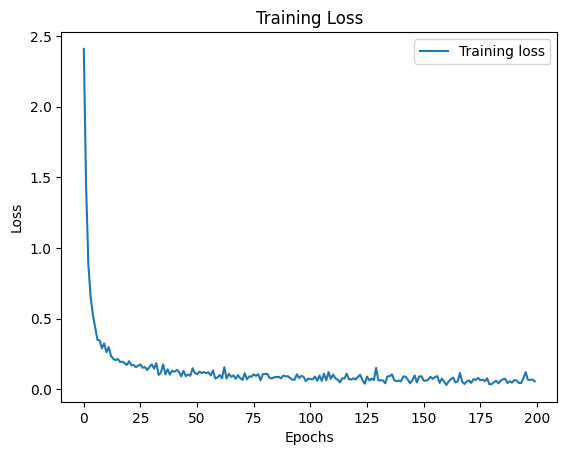

In [ ]:
# plot the losses
plt.plot(train_losses, label='Training loss')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
def get_prediction(s):
 s = re.sub(r'[^a-zA-Z ]+', '', s)
 test_text = [s]
 model.eval()

 tokens_test_data = tokenizer(
 test_text,
 max_length = max_seq_len,
 pad_to_max_length=True,
 truncation=True,
 return_token_type_ids=False
 )
 test_seq = torch.tensor(tokens_test_data['input_ids'])
 test_mask = torch.tensor(tokens_test_data['attention_mask'])

 preds = None
 with torch.no_grad():
   preds = model(test_seq.to(device), test_mask.to(device))
#  preds = preds.detach().cpu().numpy()
   preds = preds.detach().cpu().numpy()
 preds = np.argmax(preds, axis = 1)
 print("Intent Identified: ", le.inverse_transform(preds)[0])
 return le.inverse_transform(preds)[0]

In [ ]:
get_prediction("why dont you introduce yourself")

Intent Identified:  NameQuery


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2673: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


'NameQuery'

In [ ]:
response_data = json.load(open('./intents_responses.json', 'r'))
response_data

{'intents': [{'tag': 'Greeting',
   'responses': ['Hi human, please tell me your GeniSys user',
    'Hello human, please tell me your GeniSys user',
    'Hola human, please tell me your GeniSys user']},
  {'tag': 'GreetingResponse',
   'responses': ['Great! Hi <HUMAN>! How can I help?',
    'Good! Hi <HUMAN>, how can I help you?',
    'Cool! Hello <HUMAN>, what can I do for you?',
    'OK! Hola <HUMAN>, how can I help you?',
    'OK! hi <HUMAN>, what can I do for you?']},
  {'tag': 'CurrentHumanQuery',
   'responses': ['You are <HUMAN>! How can I help?',
    'Your name is  <HUMAN>, how can I help you?',
    'They call you <HUMAN>, what can I do for you?',
    'Your name is <HUMAN>, how can I help you?',
    '<HUMAN>, what can I do for you?']},
  {'tag': 'NameQuery',
   'responses': ['You can call me Geni',
    'You may call me Geni',
    'Call me Geni']},
  {'tag': 'TimeQuery', 'responses': ['One moment', 'One sec', 'One second']},
  {'tag': 'Thanks',
   'responses': ['No problem!', 'H

In [ ]:
def get_response(message):
  intent = get_prediction(message)
  for i in response_data['intents']:
    if i["tag"] == intent:
      result = random.choice(i["responses"])
      break
  # print(f"Response : {result}")
  return "Intent: "+ intent + '\n' + "Response: " + result

In [49]:
res = get_response("why dont you introduce yourself")
print(res)

Intent Identified:  NameQuery
Intent: NameQuery
Response: You can call me Geni


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2673: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [ ]:
res = get_response("tell me what i am supposed to be")
print(res)

Intent Identified:  CurrentHumanQuery
Intent: CurrentHumanQuery
Response: Your name is <HUMAN>, how can I help you?


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2673: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [52]:
data = {
    "model_state": model.state_dict(),
    "input_size": max_seq_len,
    "output_size": NUM_CLASSES,
    "tags": np.unique(df['label_text']),
    "label_mapping": LABEL_MAPPING,
    "inverse_label_mapping": INVERSE_LABEL_MAPPING
}

FILE = "data.pth"
torch.save(data, FILE)

print(f'training complete. file saved to {FILE}')

training complete. file saved to data.pth
